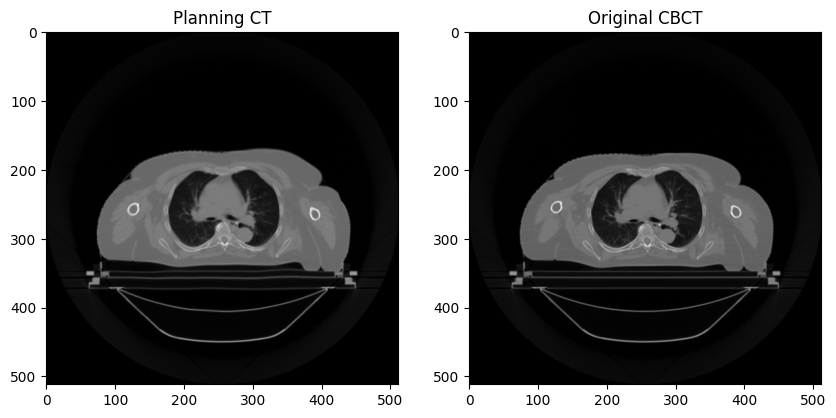

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tranformation_utils import *

# Define file paths and load images.
DATASET_PATH = "dataloader/data/full/SAMPLE_001"
planned_ct_path = f'{DATASET_PATH}/CT.1.2.246.352.221.49998588991250185596277084171475165836.dcm'
cbct_path = f'{DATASET_PATH}/CT.1.2.246.352.221.505160349897793889516650021650971788930.dcm'

# Read the images and drop the extra dimension.
planning_ct = sitk.ReadImage(planned_ct_path)[:, :, 0]
cbct = sitk.ReadImage(cbct_path)[:, :, 0]

def get_array(image):
    """Helper function to convert a SimpleITK image to a numpy array for visualization."""
    return sitk.GetArrayFromImage(image)

# Optionally display original images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(get_array(planning_ct), cmap='gray')
plt.title("Planning CT")
plt.subplot(1, 2, 2)
plt.imshow(get_array(cbct), cmap='gray')
plt.title("Original CBCT")
plt.show()

def shift_image(image, shift):
    """
    Applies a translation shift to a SimpleITK image.
    
    Parameters:
        image (SimpleITK.Image): The image to be shifted.
        shift (tuple): The translation offset for each dimension (e.g., (dx, dy)).
    
    Returns:
        SimpleITK.Image: The shifted image.
    """
    # Create a translation transform with the given shift.
    transform = sitk.TranslationTransform(image.GetDimension())
    transform.SetOffset(shift)
    
    # Resample the image using the translation transform.
    shifted_image = sitk.Resample(image, image, transform, 
                                  sitk.sitkLinear, -1000, image.GetPixelID())
    return shifted_image

# Apply a shift to the CBCT image.
# For a 2D image, the shift is defined as (dx, dy) in physical units (typically mm if spacing is set)
# Here we use arbitrary values; adjust as needed based on your image spacing.
shift_offset = (2.0, 2.0)  # shift 10 mm in x-direction and 15 mm in y-direction
cbct_shifted = shift_image(cbct, shift_offset)

cbct = cbct_shifted
planning_ct_img = sitk.GetArrayFromImage(planning_ct)
cbct_img = sitk.GetArrayFromImage(cbct)

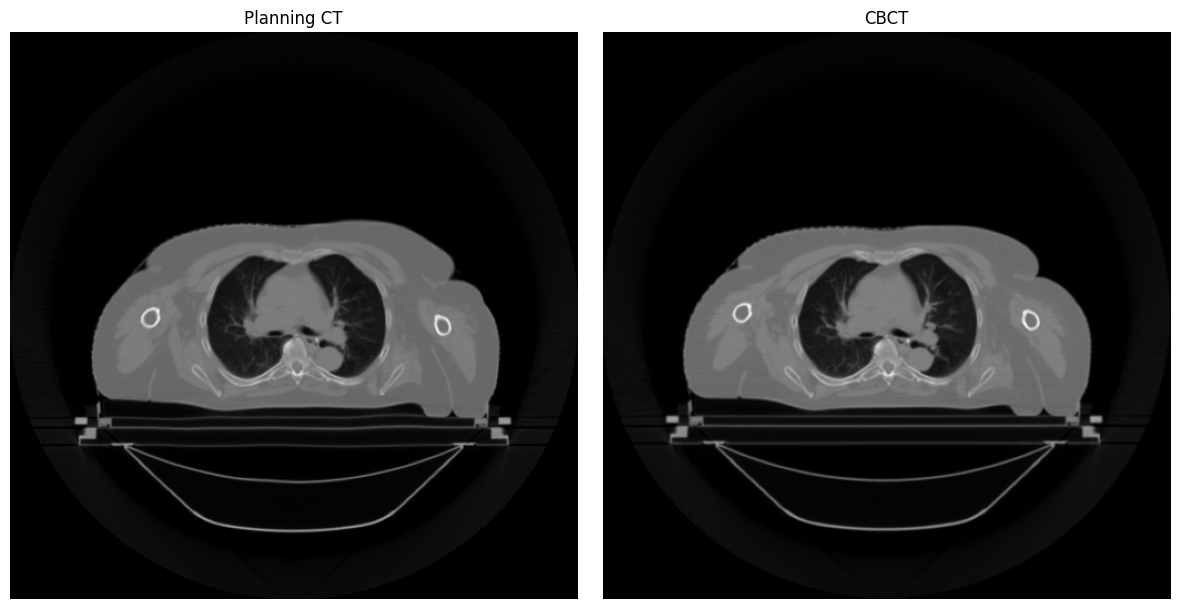

In [ ]:
plot_images(planning_ct, cbct)

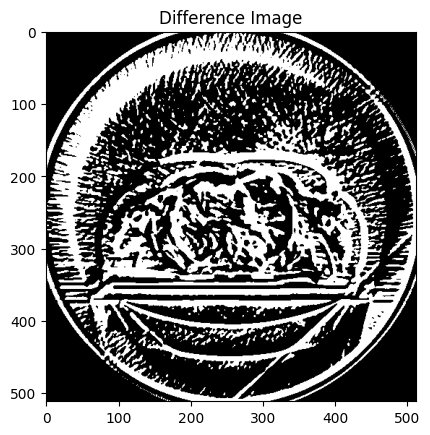

In [3]:
smoothed_planning = sitk.SmoothingRecursiveGaussian(planning_ct, sigma=2.0)
smoothed_cbct = sitk.SmoothingRecursiveGaussian(cbct, sigma=2.0)
    
plot_difference(smoothed_planning, smoothed_cbct)


itk::simple::Euler2DTransform
 Euler2DTransform (0x7f79da80ded0)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 3
   Modified Time: 55851
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 -0.000733861 
     0.000733861 1 
   Offset: [-2.01912, -2.09448]
   Center: [-0.6914, 95.3086]
   Translation: [-2.08906, -2.09502]
   Inverse: 
     1 0.000733861 
     -0.000733861 1 
   Singular: 0
   Angle: 0.000733861



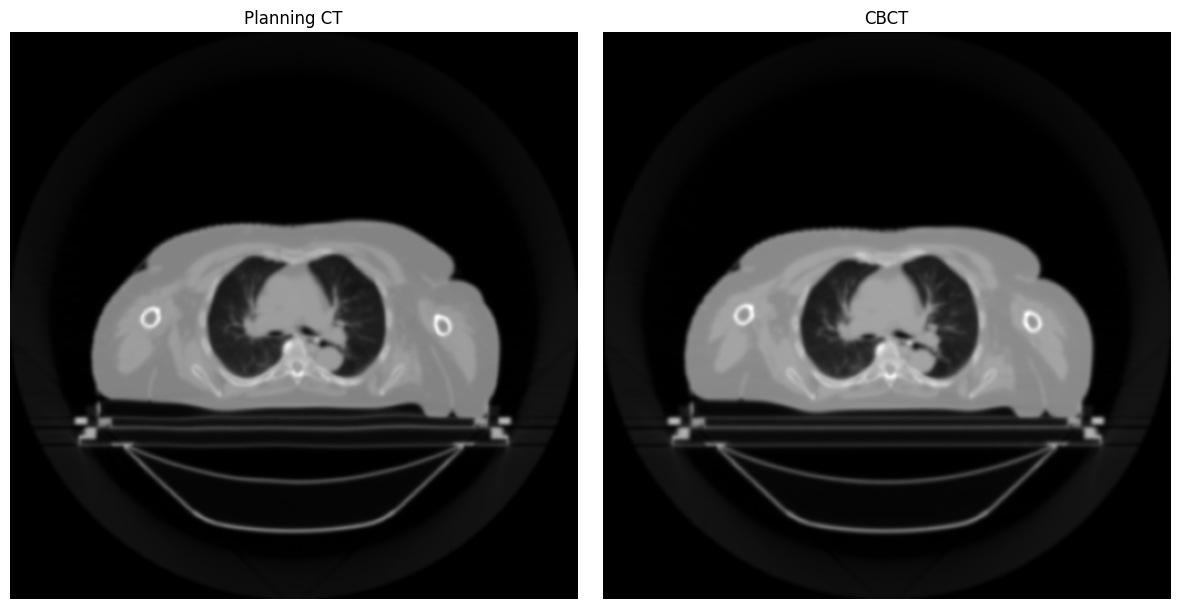

In [4]:
# def perform_rigid_registration_v2(fixed_image, moving_image, sampling_percentage=0.1, learning_rate=1.0, num_iterations=100):
#     """
#     Performs rigid registration using SimpleITK's ImageRegistrationMethod.

#     Args:
#         fixed_image (sitk.Image): The reference image.
#         moving_image (sitk.Image): The image to align to the fixed image.
#         sampling_percentage (float): Fraction of pixels used for metric evaluation (e.g., 0.1 for 10%).
#         learning_rate (float): Step size for the optimizer.
#         num_iterations (int): Maximum number of optimizer iterations.

#     Returns:
#         sitk.Transform: The calculated rigid transform, or None if registration fails.
#     """
#     if fixed_image.GetDimension() != moving_image.GetDimension():
#         print("Error: Fixed and moving images must have the same dimension.")
#         return None
#     # --- Initial Transform ---
#     # Initialize with a rigid transform centered using image geometry.
#     is_3d = fixed_image.GetDimension() == 3
#     initial_transform = sitk.CenteredTransformInitializer(
#         fixed_image,
#         moving_image,
#         sitk.Euler3DTransform() if is_3d else sitk.Euler2DTransform(),
#         sitk.CenteredTransformInitializerFilter.GEOMETRY
#     )

#     # --- Registration Method Setup ---
#     registration_method = sitk.ImageRegistrationMethod()

#     # 1. Metric: Mattes Mutual Information
#     # Good for multi-modality or mono-modality registration.
#     registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
#     # Use a percentage of pixels for metric calculation for speed. Increase for stability.
#     registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
#     registration_method.SetMetricSamplingPercentage(sampling_percentage)

#     # 2. Interpolator: Linear interpolation is standard.
#     registration_method.SetInterpolator(sitk.sitkLinear)

#     # 3. Optimizer: Gradient Descent
#     # Often more robust than RegularStepGradientDescent.
#     # Adjust learningRate and numberOfIterations as needed.
#     registration_method.SetOptimizerAsGradientDescent(
#         learningRate=learning_rate,
#         numberOfIterations=num_iterations,
#         convergenceMinimumValue=1e-6, # Stop if metric value change is small
#         convergenceWindowSize=10      # Over how many iterations to check convergence
#     )

#     # 4. Optimizer Scaling: Crucial for balancing rotation and translation steps.
#     # Scales parameters based on the expected physical shift caused by a unit change.
#     registration_method.SetOptimizerScalesFromPhysicalShift()

#     # 5. Initial Transform: Set the starting point for the optimizer.
#     registration_method.SetInitialTransform(initial_transform)

#     try:
#         final_transform = registration_method.Execute(
#             sitk.Cast(fixed_image, sitk.sitkFloat32), # Ensure float type
#             sitk.Cast(moving_image, sitk.sitkFloat32)
#         )

#         print(final_transform)
        

#         return final_transform

#     except Exception as e:
#         print(f"Error during registration execution: {e}")
#         return None

# Example usage for global alignment:
global_transform = perform_rigid_registration_v2(smoothed_planning, smoothed_cbct)
# Resample to align moving image using the rigid transform.
moving_image_global_aligned = sitk.Resample(smoothed_cbct, smoothed_planning, global_transform,
                                              sitk.sitkLinear, -1000, smoothed_cbct.GetPixelID())

plot_images(smoothed_planning, moving_image_global_aligned)

In [ ]:

fixed_image = smoothed_planning   # e.g., planning CT (fixed)
moving_image = moving_image_global_aligned           # e.g., CBCT (moving)

# Perform deformable registration.
final_bspline_transform = perform_bspline_registration(fixed_image, moving_image, grid_physical_spacing=[50.0, 50.0, 50.0], number_of_iterations=200)

# Apply the BSpline transform to get the deformed (fused) image.
fused_deformed_image = resample_with_transform(moving_image, fixed_image, final_bspline_transform)

Final BSpline registration metric value: -1.5447145804396352
Optimizer's stopping condition: LBFGSBOptimizerv4: Function tolerance reached after 139 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).


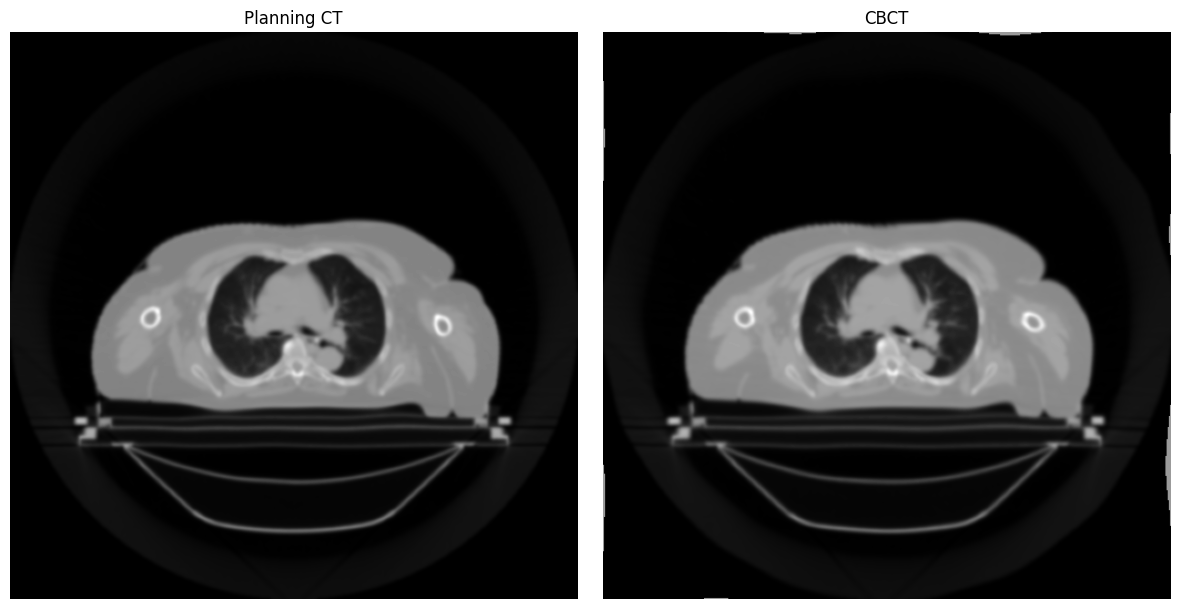

In [6]:
plot_images(fixed_image, fused_deformed_image)

In [ ]:
control_point_spacing_2d = [40.0, 40.0] # Example: 4cm grid spacing in 2D

final_deformable_transform_2d = perform_bspline_deformable_registration_2d(
    fixed_image=smoothed_planning,
    moving_image=moving_image_global_aligned, # Use the globally aligned image
    grid_physical_spacing=control_point_spacing_2d,
    sampling_percentage=0.2, # Maybe increase sampling for 2D?
    num_iterations=50
)

print("\n2D Deformable registration successful.")
# Apply the final composite transform to the *original* moving image
moving_image_deformably_aligned_2d = sitk.Resample(
    moving_image_global_aligned,             # Original 2D moving image
    smoothed_planning,         # Reference space (2D fixed image)
    final_deformable_transform_2d,# The final (possibly composite) 2D transform
    sitk.sitkLinear,
    -1000, # Background value
    moving_image_global_aligned.GetPixelID()
)


LBFGSBOptimizerv4 (0x7f79da806780): LBFGSB optimizer does not support scaling. All scales are set to one.



LBFGSBOptimizerv4 (0x7f79da806780): LBFGSB optimizer does not support scaling. All scales are set to one.

LBFGSBOptimizerv4 (0x7f79da806780): LBFGSB optimizer does not support scaling. All scales are set to one.



Final metric value: -1.434904

2D Deformable registration successful.


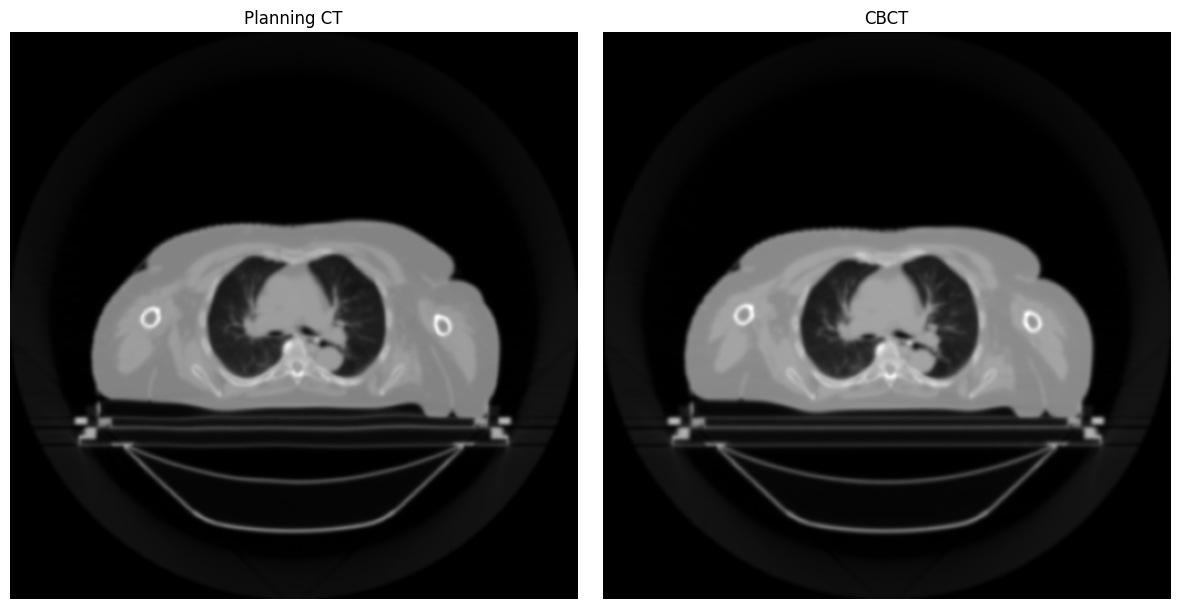

In [8]:
plot_images(smoothed_planning, moving_image_deformably_aligned_2d)

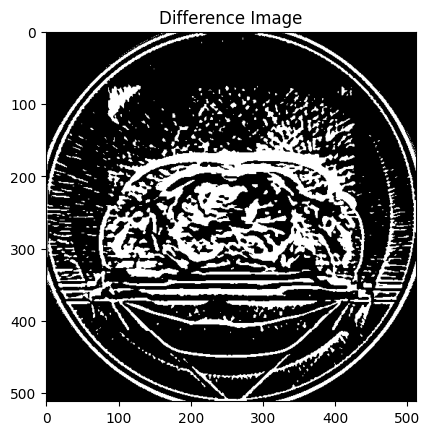

In [11]:
plot_difference(smoothed_planning, moving_image_deformably_aligned_2d)